<a href="https://colab.research.google.com/github/qiuyuzhai/-/blob/main/Train_Your_first_PyTorch_Model_%5BCard_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

从kaggle博主那里导入他的数据集，每次都分配到临时colab空间中，记住分配的路径就好

In [1]:
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/cards-image-datasetclassification')

print('Data source import complete.')
print(f"数据集已下载至： {gpiosenka_cards_image_datasetclassification_path}")


Using Colab cache for faster access to the 'cards-image-datasetclassification' dataset.
Data source import complete.
数据集已下载至： /kaggle/input/cards-image-datasetclassification


# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop循环

Almost every pytorch model training pipeline管道 meets this paradigm模范.

In [2]:
import torch
import torch.nn as nn #与神经网络有关
import torch.optim as optim#定义优化器
from torch.utils.data import Dataset, DataLoader#数据库
import torchvision#图像处理
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm#图像处理的架构

import matplotlib.pyplot as plt #可视化
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch version 2.8.0+cu126
Torchvision version 0.23.0+cu126
Numpy version 2.0.2
Pandas version 2.2.2


# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [3]:
#Dataset 是一个 “基础数据集模板”（PyTorch 提供的工具），而 PlayingCardDataset 是在它的基础上定制的 “扑克牌数据集模板”，继承了基础模板的所有功能，还可以添加自己的特色功能。
class PlayingCardDataset(Dataset):
    #init:当你用这个类创建具体实例时，它会自动运行
    #self:具体实例本身
    #transform：可选参数，用来对图片进行预处理（比如缩放、旋转等），默认 None 表示不处理
    #用 PyTorch 提供的 ImageFolder 工具，自动读取 data_dir 文件夹里的图片
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    #以下len,getitem也都是类的特殊方法

    #获取dataset长度：有几张图片
    def __len__(self):
        return len(self.data)

    #获取指定元素
    def __getitem__(self, idx):
        return self.data[idx]

    @property#属性
    def classes(self):
        #mageFolder 类有一个属性叫 classes，它会返回一个列表，这个列表包含了数据集中所有类别的名称
        return self.data.classes

## Create Test Dataset

In [4]:
#创个实例
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification'
)

In [5]:
len(dataset)

8154

1


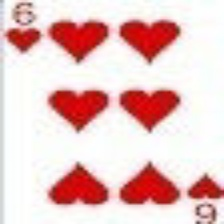

In [6]:
image, label = dataset[6000]
print(label)
image

当你在Python中使用PyTorch或TensorFlow等库处理图像时，一张图像的生命周期通常是这样的：

读取：从文件（如.jpg）中读取图像。

转换为张量：库会将其从一个图像格式转换成一个NumPy数组或多维数组（即张量）。例如，会得到一个形状为 (1080, 1920, 3) 的张量，数据类型通常是uint8（0-255的整数）。

预处理：为了喂给神经网络，通常需要进行一些处理：

调整大小：例如，将所有图片缩放到 (224, 224, 3)。

数据类型转换：将整数值[0, 255]转换为浮点数[0.0, 1.0]。

归一化：进一步将数值标准化，例如减去均值除以标准差，使其分布更适合模型训练。

调整维度顺序：有些框架（如PyTorch）喜欢通道在前（Channel-first）的格式，所以需要将张量从(高， 宽， 通道) 转换为 (通道， 高， 宽)，例如 (3, 224, 224)。

批处理：训练时不会一张一张地处理，而是将多张图片组合成一个批次（Batch）。这时，单张图片张量 (3, 224, 224) 就变成了一个4维张量 (批量大小, 通道, 高, 宽)，例如 (64, 3, 224, 224)。

In [7]:
# Get a dictionary associating target values with folder names
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
#ImageFolder(data_dir) 临时创建一个数据集加载器，它会自动识别 data_dir 下的子文件夹（每个子文件夹对应一个类别）
#class_to_idx 是 ImageFolder 自带的属性，返回一个字典：{类别名称: 标签值}
#字典的 items() 方法是 Python 内置的功能，作用是把字典中的 “键 - 值对” 以列表形式返回，例如输出：dict_items([('红桃A', 0), ('黑桃K', 1), ('方块Q', 2)])
#把items的数据用k,v分别装载，然后用v:k的方式输出
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)
#看上面的例子41号就是黑桃10

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [8]:
#Compose 可以理解为 “组合” 或 “整合” 的意思，它是 PyTorch 中专门用来把多个图像预处理处理步骤整合起来的工具，图像会按顺序依次经过所有预处理步骤，不用手动逐个调用步骤
transform = transforms.Compose([
    #把图像调整为宽 128 像素、高 128 像素。统一后才好批量处理。
    transforms.Resize((128, 128)),
    #PyTorch 模型只能处理 Tensor 格式的数据
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [9]:
dataset[100]
#输出的结果变成了张量

(tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0078, 0.0431,  ..., 0.0196, 0.0039, 0.0078],
          [0.0235, 0.0392, 0.3490,  ..., 0.2392, 0.0314, 0.0118],
          ...,
          [0.0039, 0.0235, 0.2392,  ..., 0.2196, 0.0314, 0.0118],
          [0.0039, 0.0039, 0.0235,  ..., 0.0118, 0.0078, 0.0039],
          [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0392,  ..., 0.0196, 0.0039, 0.0078],
          [0.0078, 0.0275, 0.3373,  ..., 0.2392, 0.0275, 0.0078],
          ...,
          [0.0039, 0.0235, 0.2431,  ..., 0.2196, 0.0314, 0.0078],
          [0.0039, 0.0039, 0.0235,  ..., 0.0157, 0.0078, 0.0039],
          [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0039]],
 
         [[0.0196, 0.0196, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0078, 0.0353,  ..., 0.0157, 0.0039, 0.0078],
          [0.0118, 0.0196, 0.3137,  ...,

这是一张图的张量，
  
由最外面的中括号的数量为3看出这是个3维张量，很可能是RGB图像的，

分成了R,G,B三大类，每一大类都是同一张图的不同特征分析，根据输出，假设省略号分别为A和B，则该图大小为（6+A）×（6+B）

In [10]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [11]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

- Batching our dataset批量处理
- It's faster to train the model in batches instead of one at a time.批量训练比单个训练快

In [12]:
#DataLoader(...)是 PyTorch 提供的一个类，专门用来 “包装” 数据集，实现批量加载、打乱顺序、多线程加载等功能
#batch_size=32表示 “每次从数据集中取 32 个样本”，组成一个 “批次（batch）”
#shuffle=True：在每个 epoch（遍历完整个数据集）之前，把所有样本的顺序打乱
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
for images, labels in dataloader:
    break

In [14]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

labels.shape输出即标签（类）的个数

In [15]:
labels

tensor([ 4,  1, 16, 16, 21, 29, 49, 24, 46, 29, 50, 35, 18, 24,  4, 30, 36,  5,
        21, 16,  6,  8, 18, 27,  3, 10, 46, 49, 41,  6, 24,  6])

# Step 2. Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.
- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


In [16]:
#自定义神经网络模型:PyTorch 中，all神经网络模型都应继承自 nn.Module 这个基类
class SimpleCardClassifer(nn.Module):
    #初始化方法：定义模型的所有组成部分（1.特征提取器。2.分类器）
    def __init__(self, num_classes=53):
        #（必须的步骤）调用父类 nn.Module 的初始化方法
        super(SimpleCardClassifer, self).__init__()

        # timm 库加载一个预训练的 EfficientNet-B0视觉模型
        #pretrained=True 表示使用在 ImageNet 数据集上预训练好的权重，这样模型已经具备了强大的特征提取能力。
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

        #模型拆解+特征提取器构建
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        #EfficientNet-B0 最后一个卷积层输出的特征维度
        enet_out_size = 1280 #这是EfficientNet-B0架构设计的输出维度，死的

        # 自定义分类器
        self.classifier = nn.Sequential(
    nn.Flatten(),  # 将 [batch, 1280, 1, 1] 变为 [batch, 1280]
    nn.Linear(enet_out_size, num_classes)
)


    #向前传播方法
    #定义了输入数据 x 如何经过各层得到最终输出
    def forward(self, x):
        # 输入图像先通过EfficientNet 特征提取器
        x = self.features(x)

        #取的特征再通过自定义的分类器得到最终输出
        output = self.classifier(x)
        return output


迁移方法：在ImageNet上预训练好的EfficientNet（学霸），保留"基础知识"（特征提取器），只换掉"最后一章"（分类器）

自定义器那里：nn.Sequential是全连接层。在进行输出 = 权重矩阵 × 输入特征 + 偏置向量，权重矩阵形状：[53, 1280]

以红桃心为例子：
假设1280个特征中：

特征#23：衡量"红色程度"（值=0.9）

特征#45：衡量"圆形程度"（值=0.8）

特征#78：衡量"数字存在"（值=0.7）

对于"红心A"这个类别，Linear层会学习：

给特征#23很大的正权重（比如+2.0）

给特征#45很大的正权重（比如+1.8）

给特征#78很大的正权重（比如+1.5）

那么"红心A"的分数就是：
0.9×2.0 + 0.8×1.8 + 0.7×1.5 + ... ≈ 很高的正分数

权重一开始是随机的，后来根据对比结果和预测，反向传播调整权重

EfficientNet不是一个人，而是一个家族的高效神经网络架构，由Google Research在2019年提出。

它的核心思想是：用更少的参数和计算量，达到更好的性能。EfficientNet-B0是这个家族中最基础的版本，在性能和效率之间取得了很好的平衡。

ImageNet是一个庞大的图像数据库，由斯坦福大学李飞飞教授团队创建。

规模：包含超过1400万张图像，覆盖2万多个类别

内容：有猫狗、汽车、食物、日常物品等几乎所有你能想到的物体类别

重要性：它是计算机视觉领域的"基础训练集"，相当于机器学习界的"教科书"

当说"使用ImageNet预训练权重"时，意思是：这个EfficientNet模型已经在ImageNet这个"教科书"上学习过了，已经具备了识别各种视觉特征的能力。

分类器为什么维度高达1280？
想象你要向别人描述一张猫的图片：

低级描述："这是3×224×224个彩色点"（原始像素）

高级描述："它有尖耳朵、胡须、毛茸茸的纹理、竖瞳..."（这些就是"特征"）

EfficientNet提取的1280维特征，就相当于用1280个不同的角度来描述这张图片：

第1个数字：可能代表"耳朵尖度"

第2个数字：可能代表"胡须明显程度"

第3个数字：可能代表"毛茸茸程度"

...

第1280个数字：可能代表某种纹理pattern

所以1280不是图片的尺寸，而是用1280个特征值来描述图片！

224×224 是ImageNet预训练模型的标准输入尺寸之一

In [22]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [18]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Step 3. The training loop

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for.


In [23]:
# 损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
criterion(example_out, labels)


tensor(4.0035, grad_fn=<NllLossBackward0>)

可以看到这个损失值还是很高的，因为我们还没拿我们的数据训练模型

## Setup Datasets
数据预处理+划分好数据集（训练/验证/测试）

训练集：逐步学习、迭代更新权重

验证集：判断 “当前权重是否靠谱”，指导人们调整超参数比如学习率、网络层数，这些是训练前 / 训练中需要人为或自动调整的参数，而非模型自己学的权重）

In [25]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/kaggle/input/cards-image-datasetclassification/train/'
valid_folder = '/kaggle/input/cards-image-datasetclassification/valid/'
test_folder = '/kaggle/input/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [26]:
# Simple training loop
# 整个数据集会被训练5次
num_epochs = 5
train_losses, val_losses = [], []

# 选择训练设备：优先使用GPU(cuda)，如果没有则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
# model.parameters()表示需要优化的模型参数（权重和偏置）
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # 将模型设置为训练模式：启用dropout、批量归一化的训练行为等
    model.train()
    # 用于累积当前epoch的训练损失
    running_loss = 0.0

    # 遍历训练数据加载器，tqdm用于显示进度条
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # 将输入图像和标签移动到指定设备（GPU/CPU）
        images, labels = images.to(device), labels.to(device)
        # 清空优化器的梯度，防止梯度累积
        optimizer.zero_grad()
        # 前向传播：将图像输入模型，得到预测输出
        outputs = model(images)
        # 计算当前批次的损失：预测输出与真实标签的差异
        loss = criterion(outputs, labels)
        # 反向传播：计算损失对各参数的梯度
        loss.backward()
        # 参数更新：根据梯度调整模型参数
        optimizer.step()
        # 累积损失：loss.item()是当前批次的平均损失，乘以批次大小得到总损失
        running_loss += loss.item() * labels.size(0)

    # 计算当前epoch的平均训练损失（总损失除以训练集样本总数）
    train_loss = running_loss / len(train_loader.dataset)
    # 记录当前epoch的训练损失
    train_losses.append(train_loss)

    # Validation phase-验证阶段
    # 将模型设置为评估模式：关闭dropout、固定批量归一化参数等
    model.eval()
    running_loss = 0.0

    #关闭梯度计算，节省内存并加速计算：验证阶段不需要计算梯度，因为不需要更新参数
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5475327420710017, Validation loss: 0.3254601260401168


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5492514371715588, Validation loss: 0.2363424075099657


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3254163365142668, Validation loss: 0.21656405397181241


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.25701061128819475, Validation loss: 0.11721370445107514


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19233830381040182, Validation loss: 0.1735976221426478


训练损失：衡量模型对 “已知数据” 的拟合效果，是模型学习过程的 “即时反馈”。

验证损失：衡量模型对 “未知数据” 的预测能力，是判断模型是否实用的 “关键指标”。

# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



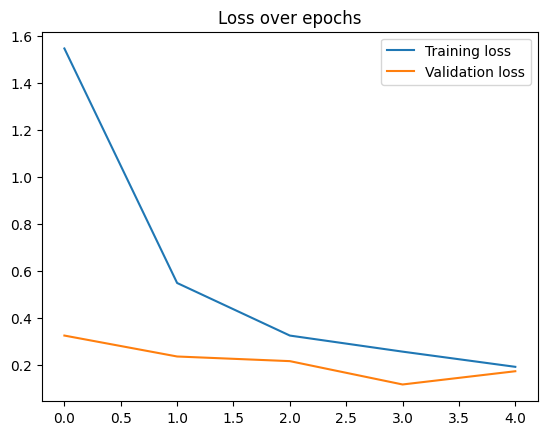

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# **Bonus:** Evaluating the Results



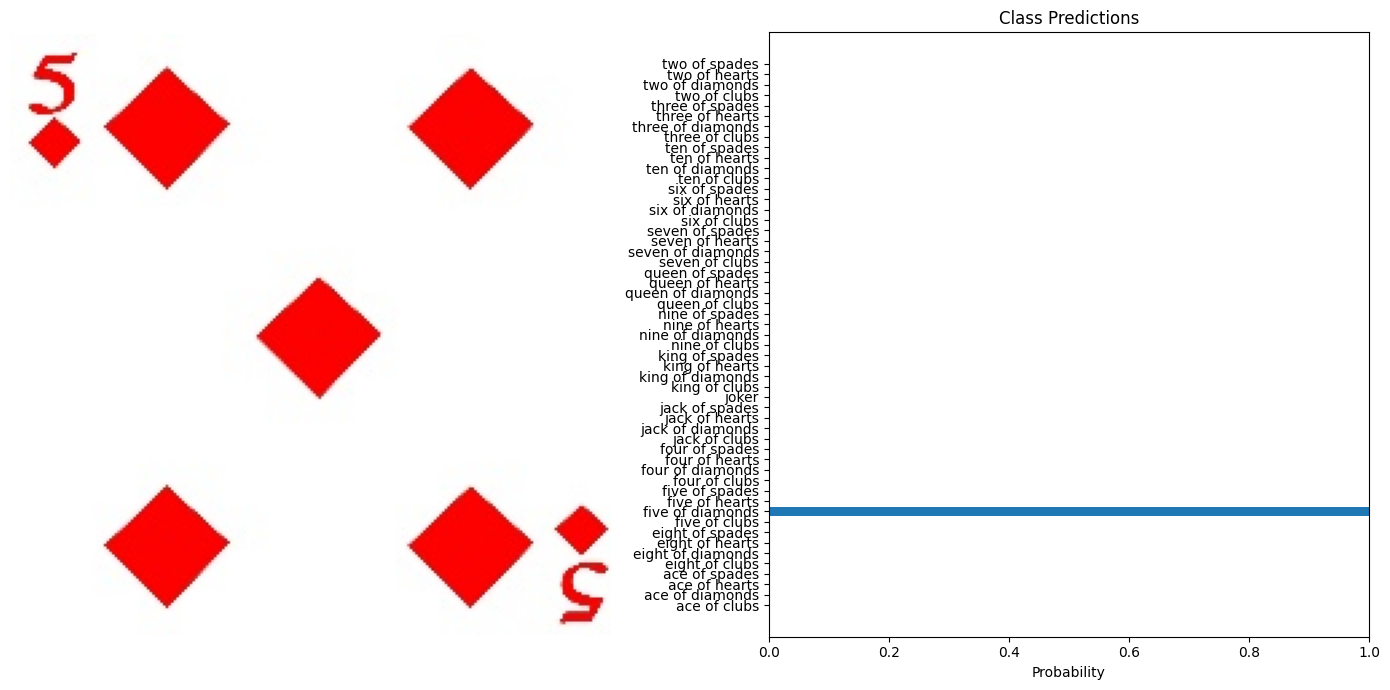

In [28]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

# Todo

- Calculate the accuracy of our model on the validation and test set.